<a href="https://colab.research.google.com/github/Elman295/Crowd_Counting_Density_Estimation/blob/main/Crowd_counting_density_estimation_LinkNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [37]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 20.0 MB/s eta 0:00:00


In [38]:
import segmentation_models_pytorch as smp

import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
import zipfile
from PIL import Image
import cv2

import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.nn.functional as F
import torchmetrics

#`Data`

In [3]:
data_path = os.path.join("drive", "MyDrive","DATA","ShanghaiTech_Crowd_Counting_Dataset.zip")

with zipfile.ZipFile(data_path, "r") as f:
  f.extractall("data")

In [4]:
train_A_path = os.path.join("data", "ShanghaiTech_Crowd_Counting_Dataset", "part_A_final", "train_data")
test_A_path = os.path.join("data", "ShanghaiTech_Crowd_Counting_Dataset", "part_A_final", "test_data")

train_B_path = os.path.join("data", "ShanghaiTech_Crowd_Counting_Dataset", "part_B_final", "train_data")
test_B_path = os.path.join("data", "ShanghaiTech_Crowd_Counting_Dataset", "part_B_final", "test_data")

In [5]:
image_train_A = os.path.join(train_A_path, "images")
gt_train_A = os.path.join(train_A_path, "ground_truth")

image_test_A = os.path.join(test_A_path, "images")
gt_test_A = os.path.join(test_A_path, "ground_truth")

image_train_B = os.path.join(train_B_path, "images")
gt_train_B = os.path.join(train_B_path, "ground_truth")

image_test_B = os.path.join(test_B_path, "images")
gt_test_B = os.path.join(test_B_path, "ground_truth")

(654, 1024, 3)


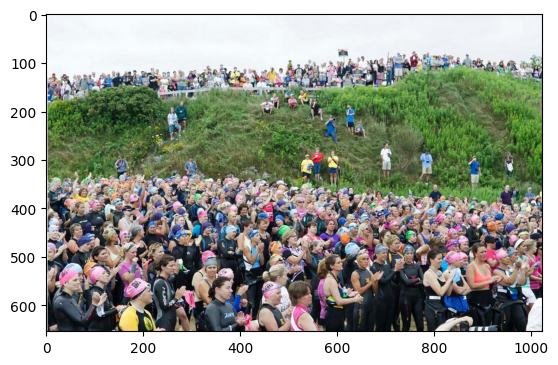

In [6]:
image_1 = Image.open(os.path.join(image_train_A, "IMG_100.jpg")).convert("RGB")
print(np.array(image_1).shape)
plt.imshow(image_1)
plt.show()

In [7]:

mat_1 = scipy.io.loadmat(os.path.join(gt_train_A,"GT_IMG_100.mat"))

In [8]:

def split(data):
  x = []
  y = []

  for i in range(len(data)):
    x.append(data[i][0])
    y.append(data[i][1])

  return x,y

In [9]:
def list_2_int(data):
  l = []
  for i in data:
    l.append(int(i))

  return l

In [10]:
def create_image(x,y, image):
  image = np.array(image)
  bg = np.zeros(shape = (image.shape[0], image.shape[1]))
  # bg[:] = [0,0,0]
  for i,j in zip(x,y):

      cv2.circle(bg,(i,j),15, color = (255,255,255), thickness = -1)



  return bg


In [11]:
class Density_count(Dataset):

  def __init__(self, images_path, annotated_path, transform = None):

    self.images_path = images_path
    self.annotated_path = annotated_path
    self.tfms = transform

  def __len__(self):
    return len(os.listdir(self.images_path))

  def __getitem__(self, idx):
    image_path = os.path.join(self.images_path, f"IMG_{idx+1}.jpg")
    image = Image.open(image_path).convert("RGB")

    annotated_file = scipy.io.loadmat(os.path.join(self.annotated_path,f"GT_IMG_{idx+1}.mat"))
    count = annotated_file["image_info"][0,0][0,0][0].shape[0]
    x,y = split(annotated_file["image_info"][0,0][0,0][0])
    x,y = list_2_int(x), list_2_int(y)
    segment = create_image(x,y,image)
    count = torch.tensor(count, dtype = torch.float32)
    segment = segment / 255
    segment = Image.fromarray(np.uint8((segment)*255))


    if self.tfms is not None:
      image = self.tfms(image)
      segment = self.tfms(segment)


    return image, count, segment.view(224,224).long()


In [12]:

tfms = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor()
])

In [13]:

train_ds = Density_count(image_train_A, gt_train_A, tfms)
test_ds = Density_count(image_test_A, gt_test_A, tfms)

In [14]:
train_dl = DataLoader(dataset = train_ds, batch_size = 32, shuffle = True)

test_dl = DataLoader(dataset = test_ds, batch_size = 32, shuffle = False)

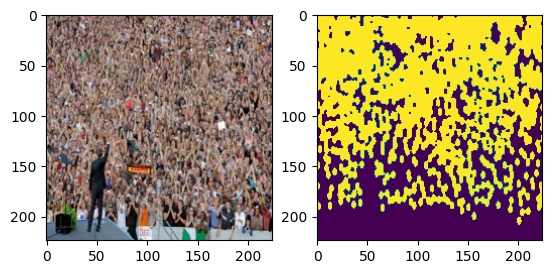

count: 1205.0
torch.float32
tensor(1)


In [15]:

image, count,segment = train_ds[250]
plt.subplot(1,2,1)
plt.imshow(image.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(segment)
plt.show()
print(f"count: {count}")
print(image.dtype)
print(segment.max())

In [16]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

#`LinkNet`

In [52]:
model = smp.Linknet(classes=2).to(device)
x=  torch.rand(size = (16,3,224,224)).to(device)
y = model(x)
print(y.shape)

torch.Size([16, 2, 224, 224])


In [53]:
loss_fn = nn.CrossEntropyLoss()

In [54]:

opt = torch.optim.Adam(params =model.parameters(), lr = 1e-3)

In [55]:

def train(data, model, loss_fn, opt):
  model.train()
  size = len(data.dataset)

  for b, (image, count, segment) in enumerate(data):

    image, count, segment = image.to(device), count.to(device), segment.to(device)
    mask_pred = model(image)
    opt.zero_grad()
    loss = loss_fn(mask_pred, segment)
    loss.backward()
    opt.step()

    if b% 100 == 0:
      print(f"loss:{loss.item()} [{b*len(image)} | {size}]")

In [56]:
def test(data, model, loss_fn):
  model.eval()

  size = len(data.dataset)
  test_acc = 0

  with torch.no_grad():
    for image,count, mask in data:
      image, mask = image.to(device), mask.to(device)
      mask_pred = model(image)
      test_acc += (mask_pred.argmax(1) == mask).type(torch.float).sum().item()

    test_acc /= size

    print(f"acc:{test_acc * 100}")

In [57]:
for e in range(50):
  print(f"epoch:{e+1}=-=-=-=-")
  train(train_dl, model, loss_fn, opt)
  # test(test_dl, model, loss_fn)

epoch:1=-=-=-=-
loss:0.8819511532783508 [0 | 300]
epoch:2=-=-=-=-
loss:0.6037019491195679 [0 | 300]
epoch:3=-=-=-=-
loss:0.4973718822002411 [0 | 300]
epoch:4=-=-=-=-
loss:0.4381052851676941 [0 | 300]
epoch:5=-=-=-=-
loss:0.3922387361526489 [0 | 300]
epoch:6=-=-=-=-
loss:0.3907453119754791 [0 | 300]
epoch:7=-=-=-=-
loss:0.3674626648426056 [0 | 300]
epoch:8=-=-=-=-
loss:0.3922952115535736 [0 | 300]
epoch:9=-=-=-=-
loss:0.3709850311279297 [0 | 300]
epoch:10=-=-=-=-
loss:0.3956373631954193 [0 | 300]
epoch:11=-=-=-=-
loss:0.38472458720207214 [0 | 300]
epoch:12=-=-=-=-
loss:0.33329302072525024 [0 | 300]
epoch:13=-=-=-=-
loss:0.30083978176116943 [0 | 300]
epoch:14=-=-=-=-
loss:0.3261428773403168 [0 | 300]
epoch:15=-=-=-=-
loss:0.30593016743659973 [0 | 300]
epoch:16=-=-=-=-
loss:0.31033191084861755 [0 | 300]
epoch:17=-=-=-=-
loss:0.3121175765991211 [0 | 300]
epoch:18=-=-=-=-
loss:0.27675679326057434 [0 | 300]
epoch:19=-=-=-=-
loss:0.26795345544815063 [0 | 300]
epoch:20=-=-=-=-
loss:0.299845874

In [58]:
jaccard = torchmetrics.JaccardIndex(task = "multiclass", num_classes=2).to(device)

accuracy: 0.8127496242523193


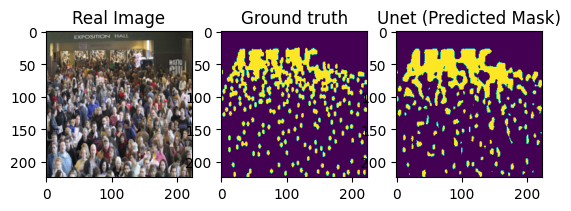

In [60]:
image, count, seg = next(iter(train_dl))
image = image.to(device)
seg = seg.to(device)
mask_pred = model(image)

print(f"accuracy: {jaccard(mask_pred,seg)}")

plt.subplot(1,3,1)
plt.title("Real Image")
plt.imshow(image[0].cpu().permute(1,2,0))
plt.subplot(1,3,2)
plt.title("Ground truth")
plt.imshow(seg[0].cpu().numpy())
plt.subplot(1,3,3)
plt.title("Unet (Predicted Mask)")
plt.imshow(mask_pred[0].cpu().detach().numpy().argmax(0))

plt.show()

accuracy: 0.6428242921829224


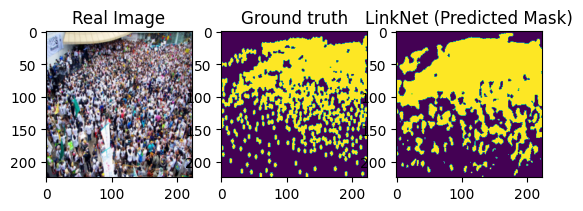

In [64]:
image, count, seg = next(iter(test_dl))
image = image.to(device)
seg = seg.to(device)
mask_pred = model(image)


print(f"accuracy: {jaccard(mask_pred,seg)}")

plt.subplot(1,3,1)
plt.title("Real Image")
plt.imshow(image[1].cpu().permute(1,2,0))
plt.subplot(1,3,2)
plt.title("Ground truth")
plt.imshow(seg[1].cpu().numpy())
plt.subplot(1,3,3)
plt.title("LinkNet (Predicted Mask)")
plt.imshow(mask_pred[1].cpu().detach().numpy().argmax(0))

plt.show()